# Phân Tích Tiền Sử Bệnh Lý và Biến Chứng

## Mục tiêu:
- Tập trung phân tích các yếu tố tiền sử bệnh lý (htn, dm, famhist) liên quan đến biến chứng
- Tính toán odds ratio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

df = pd.read_csv('../data/processed/processed_heart_disease.csv')

In [2]:
# Tạo biến biến chứng
df['has_complication'] = (df['num'] > 0).astype(int)

# Kiểm tra dữ liệu cơ bản
print(f"Tổng số bệnh nhân: {len(df)}")
print(f"Tỷ lệ biến chứng: {df['has_complication'].mean()*100:.1f}%")

Tổng số bệnh nhân: 308
Tỷ lệ biến chứng: 46.4%


### Khảo Sát Các Yếu Tố Phân Tích

In [3]:
analysis_vars = ['htn', 'dm', 'famhist']
analysis_labels = ['Tăng huyết áp', 'Đái tháo đường', 'Tiền sử gia đình']

available_vars = []
available_labels = []

for var, label in zip(analysis_vars, analysis_labels):
    if var in df.columns:
        available_vars.append(var)
        available_labels.append(label)
        count_0 = (df[var] == 0).sum()
        count_1 = (df[var] == 1).sum() 
        print(f"{label} ({var}): Không có={count_0}, Có={count_1}")
    else:
        print(f"✗ {label} ({var}): Không có trong dữ liệu")

Tăng huyết áp (htn): Không có=122, Có=186
Đái tháo đường (dm): Không có=279, Có=29
Tiền sử gia đình (famhist): Không có=113, Có=195


### Phân Tích Mối Quan Hệ Giữa Tiền Sử Bệnh Lý và Biến Chứng

TỶ LỆ BIẾN CHỨNG THEO TIỀN SỬ BỆNH LÝ:
--------------------------------------------------
Tăng huyết áp:
  Không có: 45.9% (n=122)
  Có: 46.8% (n=186)
  Chênh lệch: +0.9%

Đái tháo đường:
  Không có: 44.8% (n=279)
  Có: 62.1% (n=29)
  Chênh lệch: +17.3%

Tiền sử gia đình:
  Không có: 40.7% (n=113)
  Có: 49.7% (n=195)
  Chênh lệch: +9.0%



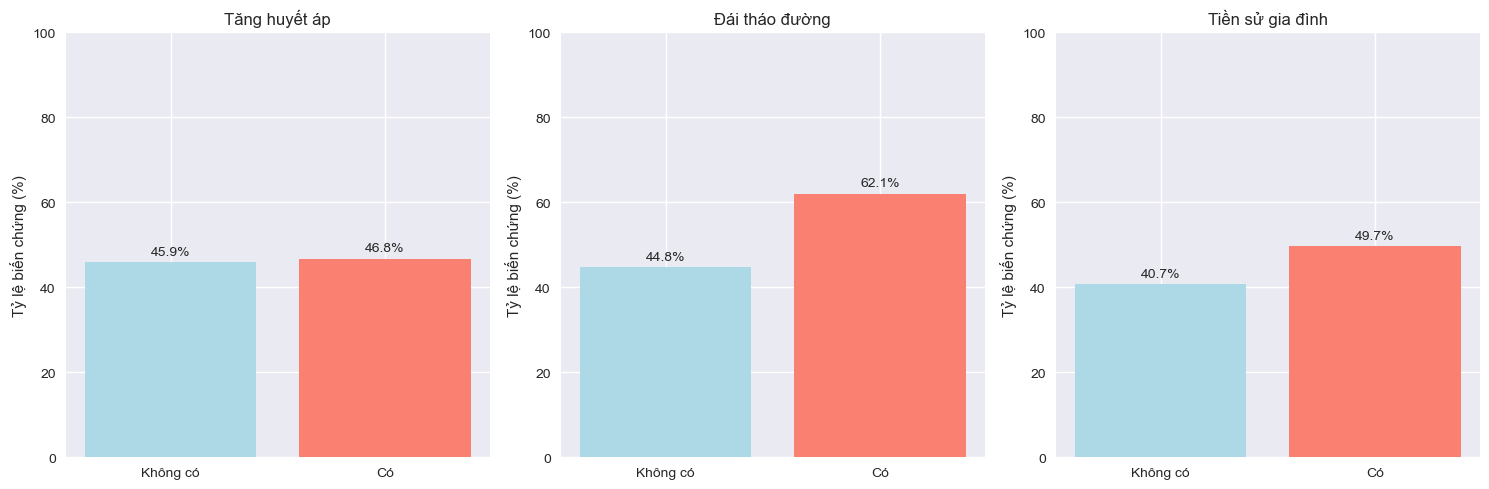

In [4]:
fig, axes = plt.subplots(1, len(available_vars), figsize=(5*len(available_vars), 5))
if len(available_vars) == 1:
    axes = [axes]

print("TỶ LỆ BIẾN CHỨNG THEO TIỀN SỬ BỆNH LÝ:")
print("-" * 50)

for i, (var, label) in enumerate(zip(available_vars, available_labels)):
    # Tính tỷ lệ biến chứng
    no_history = df[df[var] == 0]['has_complication'].mean() * 100
    with_history = df[df[var] == 1]['has_complication'].mean() * 100
    
    # Bar
    categories = ['Không có', 'Có']
    rates = [no_history, with_history]
    colors = ['lightblue', 'salmon']
    
    bars = axes[i].bar(categories, rates, color=colors)
    axes[i].set_title(label)
    axes[i].set_ylabel('Tỷ lệ biến chứng (%)')
    axes[i].set_ylim(0, 100)
    
    # Thêm nhãn trên cột
    for bar, rate in zip(bars, rates):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{rate:.1f}%', ha='center', va='bottom')
    

    count_no = (df[var] == 0).sum()
    count_yes = (df[var] == 1).sum()
    print(f"{label}:")
    print(f"  Không có: {no_history:.1f}% (n={count_no})")
    print(f"  Có: {with_history:.1f}% (n={count_yes})")
    print(f"  Chênh lệch: {with_history - no_history:+.1f}%")
    print()

plt.tight_layout()
plt.show()


### THỐNG KÊ CHI-SQUARE VÀ ODDS RATIO

In [5]:
risk_factors = []

for var, label in zip(available_vars, available_labels):
    ct = pd.crosstab(df[var], df['has_complication'])
    
    # Chỉ tính nếu có đủ dữ liệu
    if ct.shape == (2, 2):
        # Chi-square test
        chi2, p_value, _, _ = stats.chi2_contingency(ct)
        
        # Odds Ratio
        odds_ratio = (ct.iloc[1,1] * ct.iloc[0,0]) / (ct.iloc[1,0] * ct.iloc[0,1])
        
        # Tỷ lệ biến chứng
        no_history_rate = df[df[var] == 0]['has_complication'].mean() * 100
        with_history_rate = df[df[var] == 1]['has_complication'].mean() * 100
        
        risk_factors.append({
            'factor': label,
            'odds_ratio': odds_ratio,
            'p_value': p_value,
            'no_history_rate': no_history_rate,
            'with_history_rate': with_history_rate
        })
        
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        print(f"{label}:")
        print(f"  Odds Ratio: {odds_ratio:.2f} {significance}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Nguy cơ tăng: {((odds_ratio-1)*100):.0f}%")
        print()
    else:
        print(f"{label}: Không đủ dữ liệu để tính toán")


Tăng huyết áp:
  Odds Ratio: 1.04 
  p-value: 0.9734
  Nguy cơ tăng: 4%

Đái tháo đường:
  Odds Ratio: 2.02 
  p-value: 0.1144
  Nguy cơ tăng: 102%

Tiền sử gia đình:
  Odds Ratio: 1.44 
  p-value: 0.1574
  Nguy cơ tăng: 44%



### KẾT LUẬN

In [6]:
print(f"📊 TỔNG QUAN:")
print(f"  • Số bệnh nhân: {len(df):,}")
print(f"  • Tỷ lệ biến chứng chung: {df['has_complication'].mean()*100:.1f}%")
print(f"  • Yếu tố được phân tích: {len(available_vars)}")

if 'risk_factors' in locals() and len(risk_factors) > 0:
    print(f"YẾU TỐ NGUY CƠ CAO NHẤT:")
    top_factor = risk_factors[0]
    print(f"  • {top_factor['factor']}")
    print(f"  • Odds Ratio: {top_factor['odds_ratio']:.2f}")
    print(f"  • Tăng nguy cơ: {((top_factor['odds_ratio']-1)*100):.0f}%")
    print(f"  • Ý nghĩa thống kê: {'Có' if top_factor['p_value'] < 0.05 else 'Không'}")
    
if 'total_history' in df.columns:
    high_risk_patients = (df['total_history'] >= 2).sum()
    print(f"⚠️ NHÓM NGUY CƠ CAO:")
    print(f"  • Có ≥2 tiền sử: {high_risk_patients} bệnh nhân ({high_risk_patients/len(df)*100:.1f}%)")
    
    if high_risk_patients > 0:
        high_risk_rate = df[df['total_history'] >= 2]['has_complication'].mean() * 100
        print(f"  • Tỷ lệ biến chứng: {high_risk_rate:.1f}%")

📊 TỔNG QUAN:
  • Số bệnh nhân: 308
  • Tỷ lệ biến chứng chung: 46.4%
  • Yếu tố được phân tích: 3
YẾU TỐ NGUY CƠ CAO NHẤT:
  • Tăng huyết áp
  • Odds Ratio: 1.04
  • Tăng nguy cơ: 4%
  • Ý nghĩa thống kê: Không
